In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, log_loss, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

from imblearn.over_sampling import SMOTEN, RandomOverSampler
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('breast-cancer_csv.csv')

## Предобработка данных

In [3]:
df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumor-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    278 non-null    object
 5   deg-malig    286 non-null    int64 
 6   breast       286 non-null    object
 7   breast-quad  285 non-null    object
 8   irradiat     286 non-null    object
 9   Class        286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


In [5]:
for column in df.columns:
  print(column)
  print(df[column].value_counts(normalize=True, dropna=False), '\n')

age
50-59    0.335664
40-49    0.314685
60-69    0.199301
30-39    0.125874
70-79    0.020979
20-29    0.003497
Name: age, dtype: float64 

menopause
premeno    0.524476
ge40       0.451049
lt40       0.024476
Name: menopause, dtype: float64 

tumor-size
30-34    0.209790
25-29    0.188811
20-24    0.174825
15-19    0.104895
10-14    0.097902
40-44    0.076923
35-39    0.066434
0-4      0.027972
50-54    0.027972
5-9      0.013986
45-49    0.010490
Name: tumor-size, dtype: float64 

inv-nodes
0-2      0.744755
3-5      0.125874
6-8      0.059441
9-11     0.034965
15-17    0.020979
12-14    0.010490
24-26    0.003497
Name: inv-nodes, dtype: float64 

node-caps
no     0.776224
yes    0.195804
NaN    0.027972
Name: node-caps, dtype: float64 

deg-malig
2    0.454545
3    0.297203
1    0.248252
Name: deg-malig, dtype: float64 

breast
left     0.531469
right    0.468531
Name: breast, dtype: float64 

breast-quad
left_low     0.384615
left_up      0.339161
right_up     0.115385
right_low   

У нас имеется 286 наблюдений за пациентами, датасет малого размера. В целевом признаке присутствует дисбаланс классов (70:30)  
Большинство признаков представлено в виде промежутков (такие как возраст, размер опухоли). Присутствуют пропуски в признаках node-caps и breast-quad. Природа признаков неизвестна (предполагается невозможность полноценной диагностики) - заполним самым частым значением.     
Практически все признаки - категориальные, при этом:   
номинальные - menopause, node-caps, breast, breast-quad, irradiat, Class    
порядковые - age, tumor-size, inv-nodes   
При этом в признаках age, tumor_size и inv_nodes имеются редкие значения - не более 3% датасета. Более того - такое разделение не привносит значимый вклад в предсказание целевого признака. К примеру, в практической деятельности количество пораженных метастатически лимфатических узлов более 6 прогностически эквивалентно 26 и более узлам.

Переименуем признаки в snake_case, объединим редкие значения признаков. Обработку типов переменных произведем после исследовательского анализа данных
   


In [6]:
'''
Функция принимает датасет, приводит столбцы к snake_case,
объединяет редкие значения признаков, заполняет пропуски 
самыми частыми значениями.
'''
def rename_combine_fill(data):

  data.columns = data.columns.str.replace('-', '_').str.lower()
  data['age'] = data['age'].replace(['60-69', '70-79', '20-29', '30-39'], ['60-79', '60-79', '20-39', '20-39'])
  data['tumor_size'] = data['tumor_size'].replace(['0-4', '5-9', '45-49', '50-54'], ['0-9', '0-9', '45-54', '45-54'])
  data['inv_nodes'] = data['inv_nodes'].replace(['6-8', '9-11', '15-17', '12-14', '24-26'], '6-26')

  miss_columns = ['node_caps', 'breast_quad']
  for column in miss_columns:
    data[column] = data[column].fillna(data[column].mode().iloc[0])

  print('Преобразование завершено')

In [7]:
df_prep = df.copy()
rename_combine_fill(df_prep)

Преобразование завершено


## Исследовательский анализ данных

Некоторые из признаков обязаны влиять на класс больше, нежели остальные. Логично предположить, что наличие метастазов в лимфатические узлы и их экстранодальное распространение являются прогностически неблагоприятным признаком, а степень злокачественности G1 и малый размер опухоли - благоприятным. Стоит отметить, что локализация опухолевого узла обычно не играет значительной роли в определении вероятности рецидива. Для проверки наших предположений построим распределения по признаку

Сначала рассмотрим каждый признак совместно с целевым по количеству

In [8]:
sns.set_theme()
palette = {'recurrence-events': 'C0', 'no-recurrence-events': 'C1'}

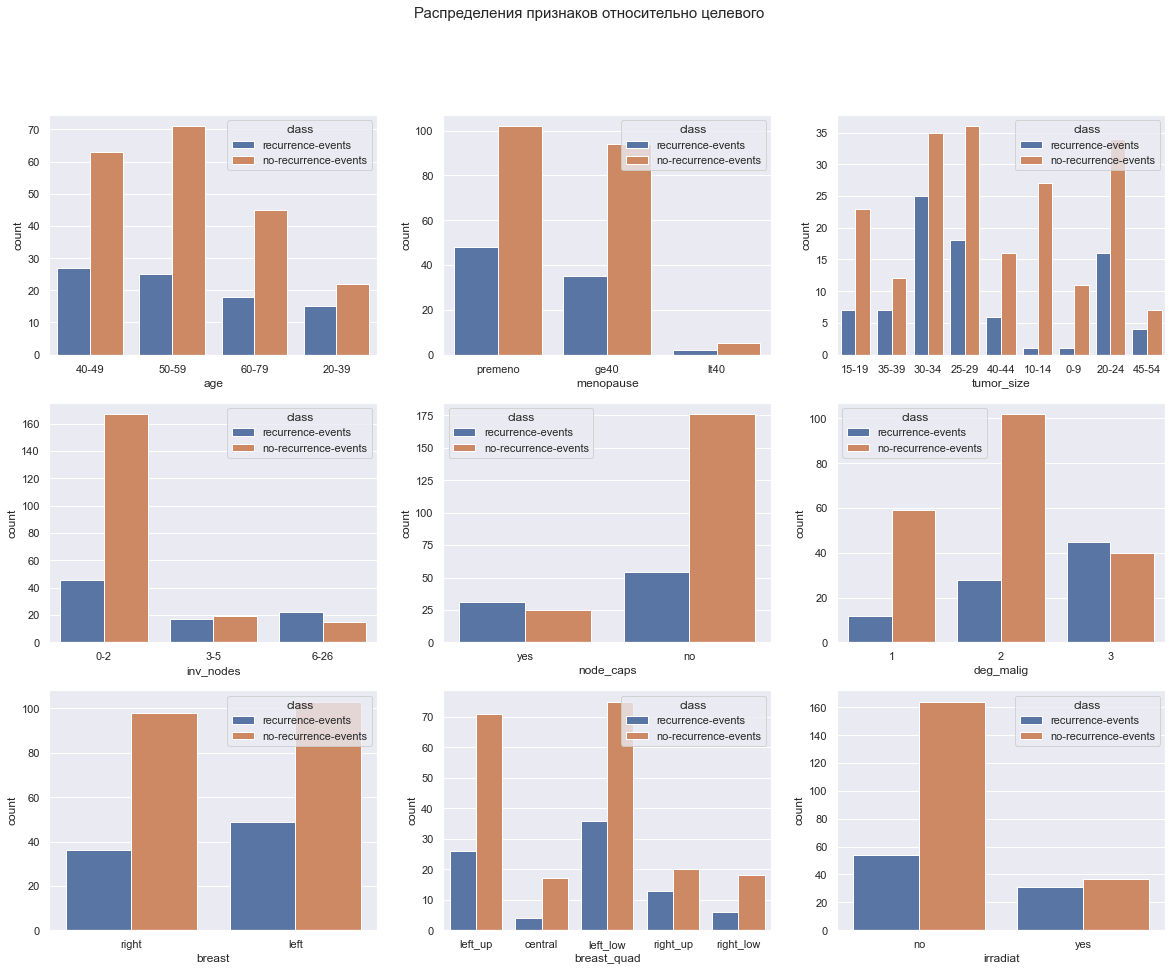

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('Распределения признаков относительно целевого', size=15)

sns.countplot(ax=axes[0,0], x="age", hue='class', data=df_prep, palette=palette)
sns.countplot(ax=axes[0,1], x="menopause", hue='class', data=df_prep, palette=palette)
sns.countplot(ax=axes[0,2], x="tumor_size", hue='class', data=df_prep, palette=palette)
sns.countplot(ax=axes[1,0], x="inv_nodes", hue='class', data=df_prep, palette=palette)
sns.countplot(ax=axes[1,1], x="node_caps", hue='class', data=df_prep, palette=palette)
sns.countplot(ax=axes[1,2], x="deg_malig", hue='class', data=df_prep, palette=palette)
sns.countplot(ax=axes[2,0], x="breast", hue='class', data=df_prep, palette=palette)
sns.countplot(ax=axes[2,1], x="breast_quad", hue='class', data=df_prep, palette=palette)
sns.countplot(ax=axes[2,2], x="irradiat", hue='class', data=df_prep, palette=palette)

pass

А также рассмотрим каждый признак в процентном соотношении с таргетом

In [10]:
columns = df_prep.columns.drop('class')
list_of_dataframes = list()

for col in columns:
  data = df_prep.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('Percent').reset_index() #группируем датафрейм по таргету, берем количество значений,
  list_of_dataframes.append(data)                                                                            #умножаем на 100, получаем проценты, сохраняем в лист

list_of_dataframes[0]

,age,class,Percent
0,20-39,no-recurrence-events,59.459459
1,20-39,recurrence-events,40.540541
2,40-49,no-recurrence-events,70.000000
3,40-49,recurrence-events,30.000000
4,50-59,no-recurrence-events,73.958333
5,50-59,recurrence-events,26.041667
6,60-79,no-recurrence-events,71.428571
7,60-79,recurrence-events,28.571429


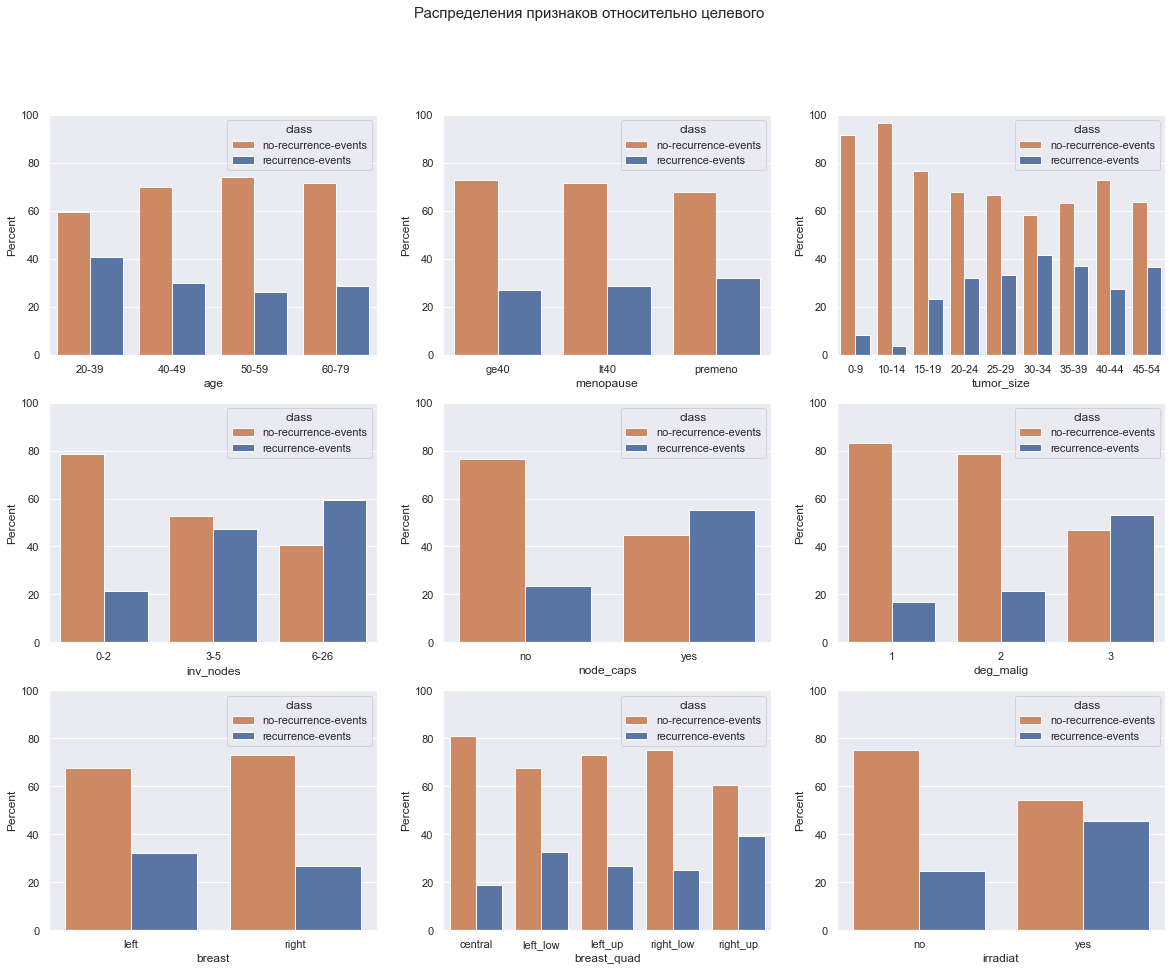

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(20,15))
plt.setp(axes, ylim=[0,100])
fig.suptitle('Распределения признаков относительно целевого', size=15)

sns.barplot(ax=axes[0,0], x='age', y='Percent', hue='class', data=list_of_dataframes[0], palette=palette)
sns.barplot(ax=axes[0,1], x='menopause', y='Percent', hue='class', data=list_of_dataframes[1], palette=palette)
sns.barplot(ax=axes[0,2], x='tumor_size', y='Percent', hue='class', data=list_of_dataframes[2], palette=palette)
sns.barplot(ax=axes[1,0], x='inv_nodes', y='Percent', hue='class', data=list_of_dataframes[3], palette=palette)
sns.barplot(ax=axes[1,1], x='node_caps', y='Percent', hue='class', data=list_of_dataframes[4], palette=palette)
sns.barplot(ax=axes[1,2], x='deg_malig', y='Percent', hue='class', data=list_of_dataframes[5], palette=palette)
sns.barplot(ax=axes[2,0], x='breast', y='Percent', hue='class', data=list_of_dataframes[6], palette=palette)
sns.barplot(ax=axes[2,1], x='breast_quad', y='Percent', hue='class', data=list_of_dataframes[7], palette=palette)
sns.barplot(ax=axes[2,2], x='irradiat', y='Percent', hue='class', data=list_of_dataframes[8], palette=palette)

pass

Нормализованное значение признаков показывает, что, вероятно, не все они будут значимы для обучения модели. Такие признаки, как `menopause`, `breast` и `breast_quad` показывают одинаковое соотношение целевого признака внутри каждой категории. Такой результат вполне логичен и ожидаем, потому что сомнительно, чтобы вероятность рецедива заболевания зависела от этих признаков.    
В свою очередь ряд признаков, таких как `tumor_size`, `inv_nodes`, `node_caps`, `deg_malig` и `irradiat` показывают увеличение процента пациентов с рецедивом в зависимости от значения признака. С высокой долей вероятности эти признаки окажутся решающими при построении модели.   
**Вывод:** необходимо произвести взвешивание признаков после их кодирования и сравнить метрики модели до и после выбора признаков.

## Работа с признаками

In [12]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumor_size   286 non-null    object
 3   inv_nodes    286 non-null    object
 4   node_caps    286 non-null    object
 5   deg_malig    286 non-null    int64 
 6   breast       286 non-null    object
 7   breast_quad  286 non-null    object
 8   irradiat     286 non-null    object
 9   class        286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


Прежде чем обучать модель, необходимо закодировать признаки. Все признаки, кроме `deg_malign`, - категориальные, часть из них - номинальные, другие - порядковые.   
Для номинальных признаков используем OneHotEncoder, для порядковых - OrdinaryEncoder. В случае последних проследим, чтобы энкодер присваивал нужные значения каждому из признаков.   
Кроме того, используя LabelBinarizer до сплита преобразуем бинарные признаки `irradiat` и `class`.
Как мы указали выше, в нашей выборке присутствует дисбаланс классов в целевом признаке (70:30). Используем технику SMOTE для избавления от дисбаланса классов.   
Прежде необходимо разбить датасет на признаки и таргет, а после - на обучающую и тестовую выборки.   

In [13]:
X = df_prep.drop('class', axis=1)
y = df_prep['class']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=47
)

print(f'Обучающая выборка: {X_train.shape}')
print(f'Обучающий таргет: {y_train.shape}')
print(f'Тестовая выборка: {X_test.shape}')
print(f'Тестовый таргет: {y_test.shape}')

Обучающая выборка: (200, 9)
Обучающий таргет: (200,)
Тестовая выборка: (86, 9)
Тестовый таргет: (86,)


Отдельно закодируем целевой признак, используя LabelBinarizer()

In [15]:
label = LabelBinarizer()
y_train = label.fit_transform(y_train)
y_test = label.transform(y_test)
y_train.shape

(200, 1)

Для обработки признаков применим следующую обработку признаков:   
для порядковых (`age`, `tumor_size`, `inv_nodes`, `node_caps`, `irradiat`) используем OrdinalEncoder,   
для номинальных (`menopause`, `breast`, `breast_quad`) используем OneHotEncoder.   
   
Соберем все преобразования в класс ColumnTransformer

In [16]:
ord_features = X[['age', 'tumor_size', 'inv_nodes', 'node_caps', 'irradiat']].columns
nom_features = X[['menopause', 'breast', 'breast_quad']].columns

In [17]:
preprocessing = ColumnTransformer(
    transformers=[
                  ('ord', OrdinalEncoder(), ord_features),
                  ('nom', OneHotEncoder(), nom_features)],
                  remainder='passthrough')

### Дисбаланс классов

Как было указано выше, в нашей выборке присутствует дисбаланс классов (~70:30), который будет отрицательно влиять на прогнозы моделей.   
Для устранения проблемы мы воспользуемся библиотекой imblearn, а именно - классом SMOTEN, который работает с категориальными переменными.     
Начнем собирать пайплайн, в который включим ColumnTransformer, созданный ранее

In [18]:
smoten = SMOTEN(random_state=47, n_jobs=-1)
pipe = Pipeline(steps=[('preprocessing', preprocessing),
                       ('SMOTEN', smoten)])

## Подбор моделей и гиперпараметров

Данные готовы к подбору и обучению моделей.   
Перед нами стоит задача классификации. Оценивать модели будем по логлоссу (так как нас интересуют вероятности, а не лейблы).   
Сначала обучим простые модели со стандартными гиперпараметрами и оценим метрику используя кросс-валидацию по 10 блокам

In [19]:
'''
Функция принимает на вход признаки, таргет и метрику.
Подготавливает лист из классификаторов, после для каждого проводит стратифицированную
кросс-валидацию по 10 блокам.
Возвращает словарь типа {имя классификатора: значение метрики}

'''

def classifiers_validation(features, target, preprocessing, disbalance, metric):
  rs = 47
  classifiers = [
                LogisticRegression(random_state=rs, solver='liblinear', penalty='l2'),
                SVC(kernel='linear', C=1.0, probability=True, random_state=rs),
                KNeighborsClassifier(n_jobs=-1),
                CategoricalNB(),
                DecisionTreeClassifier(criterion='entropy', random_state=rs),
                RandomForestClassifier(criterion='entropy', random_state=rs)
  ]

  scoring = metric
  models_and_scores = {}

  for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessing', preprocessing),
                        ('disbalance', disbalance),
                        ('classifier', classifier)])
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    score = cross_val_score(pipe, features, target, 
                            scoring=scoring, cv=cv, n_jobs=-1)
    models_and_scores.update({classifier.__class__.__name__: -score.mean()})
  
  const_05 = [0.5 for _ in y_train]                                                # После оверсэмплинга распределение классов 1:1,
  models_and_scores.update({'Constant prediction': log_loss(y_train, const_05)})   # поэтому берем вероятность каждого класса 0.5

  return models_and_scores

In [20]:
log_smoten = classifiers_validation(X_train, y_train, preprocessing, 
                                   smoten, 'neg_log_loss')
log_smoten

{'LogisticRegression': 0.6344695636124957,
 'SVC': 0.6110975575551658,
 'KNeighborsClassifier': 1.9401705520930512,
 'CategoricalNB': 0.807060363532813,
 'DecisionTreeClassifier': 12.44103490151088,
 'RandomForestClassifier': 0.7884614810774756,
 'Constant prediction': 0.6931471805599452}

Значения логлосса у базовых классификаторов неутешительные - они хуже или немногим лучше случайного предсказания. Лучше всего себя показали метод опорных векторов и линейная регрессия.    
Попробуем заменить способ борьбы с дисбалансом - заменим SMOTEN на метод обычного оверсэмплинга

In [21]:
oversample = RandomOverSampler(random_state=47)

In [22]:
log_over = classifiers_validation(X_train, y_train, preprocessing, 
                                 oversample, 'neg_log_loss')
log_over

{'LogisticRegression': 0.6887126261667321,
 'SVC': 0.6688933957310346,
 'KNeighborsClassifier': 2.753698885492715,
 'CategoricalNB': 0.7522740922371864,
 'DecisionTreeClassifier': 10.884738650276452,
 'RandomForestClassifier': 0.6220367685327607,
 'Constant prediction': 0.6931471805599452}

После изменения мы получили  прирост значений лосса у леса, но потеряли у других классификаторов. Попробуем разобраться в признаках и подобрать необходимые для поставленной задачи

## Feature selection

Базовые модели слабо показывают себя на данном датасете. Частично это влияние малого количества обучающих данных. Предположим, что не все признаки одинаково полезны для обучения моделей - некоторые вносят ненужное нам смещение.   

Воспользуемся двумя методами feature selection - хи-квадрат пирсона и статистика взаимной информации

###Chi-square feature selection:

Используем класс SelectKBest с аргументом score_func=chi2 для получения скоров для каждого признака

In [23]:
k_best_chi = SelectKBest(score_func=chi2, k='all')

In [24]:
pipe = Pipeline(steps=[('preprocessing', preprocessing),
                      ('k_best_chi', k_best_chi)])
pipe.fit(X_train, y_train)
chi_scores = np.around(pipe[1].scores_, decimals=3)

In [25]:
for i, name in enumerate(chi_scores):
  print(f'Признак {i}: {name}')

Признак 0: 0.196
Признак 1: 5.276
Признак 2: 28.291
Признак 3: 11.506
Признак 4: 7.56
Признак 5: 0.179
Признак 6: 0.265
Признак 7: 0.095
Признак 8: 0.302
Признак 9: 0.393
Признак 10: 0.291
Признак 11: 0.158
Признак 12: 1.258
Признак 13: 0.002
Признак 14: 2.051
Признак 15: 3.621


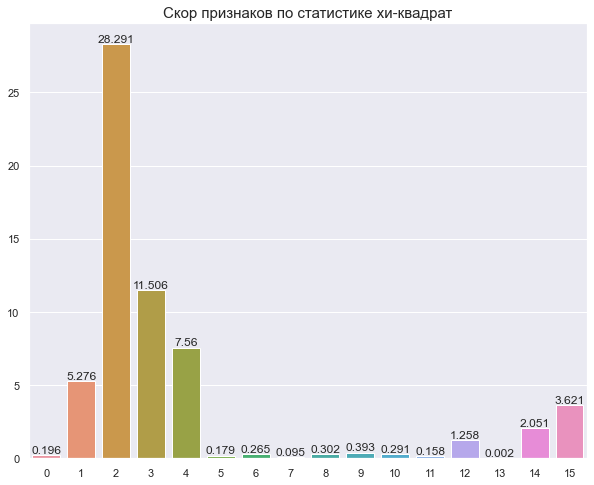

In [26]:
fig = plt.figure(figsize=(10,8))
plt.title('Скор признаков по статистике хи-квадрат', size=15)
y_data = np.around([1,2,3,11], decimals=1)
ax = sns.barplot(x=list(range(len(chi_scores))), y = chi_scores)
plt.bar_label(ax.containers[0])
pass

In [27]:
out_ind = pipe['preprocessing'].output_indices_ #нам важно понимать, какая колонка содержит какие признаки после 
trans = pipe['preprocessing'].transformers_     #трансформации 

In [28]:
print(out_ind, '\n')
print(trans)

{'ord': slice(0, 5, None), 'nom': slice(5, 15, None), 'remainder': slice(15, 16, None)} 

[('ord', OrdinalEncoder(), Index(['age', 'tumor_size', 'inv_nodes', 'node_caps', 'irradiat'], dtype='object')), ('nom', OneHotEncoder(), Index(['menopause', 'breast', 'breast_quad'], dtype='object')), ('remainder', 'passthrough', [5])]


Как мы видим на графике, согласно данному методу отбора признаков, больше всего целевой признак зависит от размера опухоли, количества вовлеченных метастатически узлов, наличия экстракапсулярного распространения метастаза, степени злокачественности рака молочной железы, проведения лучевой терапии. Некая (но весьма слабая) зависимость прослеживается между отдельными значениями квадранта молочной железы.   
Такие признаки, как возраст, менструальный статус, локализация узла слева или справа согласно данной статистике не влияют на целевой признак.   
Удалим признаки, которые имеют слабое влияние на таргет. Сохраним копии датасета и позднее обучим модели и на них тоже для сравнения перформанса

In [29]:
X_chi = df_prep.drop(['age', 'menopause', 'breast', 'class'], axis=1)
X_train_chi, X_test_chi, y_train_chi, y_test_chi = train_test_split(X_chi, y, 
                                                                    test_size=0.3,
                                                                    stratify=y,
                                                                    random_state=47)

In [30]:
label = LabelBinarizer()
y_train_chi = label.fit_transform(y_train_chi)
y_test_chi = label.transform(y_test_chi)
y_train_chi.shape

(200, 1)

### Mutual Information Feature Selection

In [31]:
k_best_mut = SelectKBest(score_func=mutual_info_classif, k='all')

In [32]:
pipe = Pipeline(steps=[('preprocessing', preprocessing),
                      ('k_best_mut', k_best_mut)])
pipe.fit(X_train, y_train)
mut_scores = np.around(pipe[1].scores_, decimals=3)

In [33]:
for i, name in enumerate(mut_scores):
  print(f'Признак {i}: {name}')

Признак 0: 0.0
Признак 1: 0.019
Признак 2: 0.017
Признак 3: 0.043
Признак 4: 0.024
Признак 5: 0.033
Признак 6: 0.0
Признак 7: 0.0
Признак 8: 0.0
Признак 9: 0.026
Признак 10: 0.0
Признак 11: 0.0
Признак 12: 0.052
Признак 13: 0.0
Признак 14: 0.031
Признак 15: 0.0


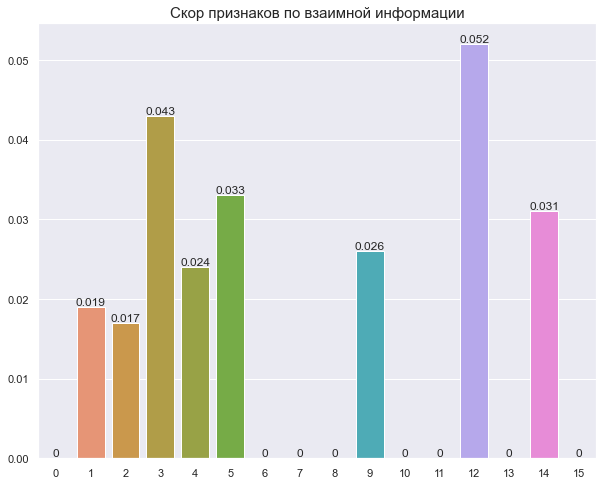

In [34]:
fig = plt.figure(figsize=(10,8))
plt.title('Скор признаков по взаимной информации', size=15)
y_data = np.around([1,2,3,11], decimals=1)
ax = sns.barplot(x=list(range(len(mut_scores))), y = mut_scores)
plt.bar_label(ax.containers[0])
pass

In [35]:
out_ind = pipe['preprocessing'].output_indices_ 
trans = pipe['preprocessing'].transformers_ 

print(out_ind, '\n')
print(trans)

{'ord': slice(0, 5, None), 'nom': slice(5, 15, None), 'remainder': slice(15, 16, None)} 

[('ord', OrdinalEncoder(), Index(['age', 'tumor_size', 'inv_nodes', 'node_caps', 'irradiat'], dtype='object')), ('nom', OneHotEncoder(), Index(['menopause', 'breast', 'breast_quad'], dtype='object')), ('remainder', 'passthrough', [5])]


Согласно этому способу отбора признаков, значимыми являются такие признаки, как 'tumor_size', 'inv_nodes', 'node_caps', 'irradiat'. Кроме того, в отличие от хи-квадрата, признаки 'menopause' и 'breast_quad' также важны для таргета, а вот признак 'malign_degree' - нет.   

Также создадим новые обучающие и тестовые выборки для данного метода

In [36]:
X_mut = df_prep.drop(['age', 'breast', 'deg_malig', 'class'], axis=1)
X_train_mut, X_test_mut, y_train_mut, y_test_mut = train_test_split(X_mut, y, 
                                                                    test_size=0.3,
                                                                    stratify=y,
                                                                    random_state=47)

In [37]:
label = LabelBinarizer()
y_train_mut = label.fit_transform(y_train_mut)
y_test_mut = label.transform(y_test_mut)
y_train_mut.shape

(200, 1)

## Проверка новых выборок 

Прежде, чем проверять метрики на моделях, необходимо внести изменения в пайплайн

In [38]:
ord_features_chi = X[['tumor_size', 'inv_nodes', 'node_caps', 'irradiat']].columns
nom_features_chi = X[['breast_quad']].columns

preprocessing_chi = ColumnTransformer(
    transformers=[
                  ('ord', OrdinalEncoder(), ord_features_chi),
                  ('nom', OneHotEncoder(), nom_features_chi)],
                  remainder='passthrough')


In [39]:
ord_features_mut = X[['tumor_size', 'inv_nodes', 'node_caps', 'irradiat']].columns
nom_features_mut = X[['menopause', 'breast_quad']].columns

preprocessing_mut = ColumnTransformer(
    transformers=[
                  ('ord', OrdinalEncoder(), ord_features_mut),
                  ('nom', OneHotEncoder(), nom_features_mut)],
                  remainder='passthrough')

In [40]:
log_chi_smoten = classifiers_validation(X_train_chi, y_train_chi, preprocessing_chi, smoten, 'neg_log_loss')
log_chi_smoten

{'LogisticRegression': 0.6491509620053462,
 'SVC': 0.6301230457533967,
 'KNeighborsClassifier': 2.7095132306926666,
 'CategoricalNB': 0.7348425780588642,
 'DecisionTreeClassifier': 9.653139138856764,
 'RandomForestClassifier': 0.8818754251347384,
 'Constant prediction': 0.6931471805599452}

In [41]:
log_chi_over = classifiers_validation(X_train_chi, y_train_chi, preprocessing_chi, oversample, 'neg_log_loss')
log_chi_over

{'LogisticRegression': 0.6714692713550334,
 'SVC': 0.6667775289659895,
 'KNeighborsClassifier': 3.244340992346597,
 'CategoricalNB': 0.7351886892271249,
 'DecisionTreeClassifier': 8.453614927518148,
 'RandomForestClassifier': 0.8019345403585888,
 'Constant prediction': 0.6931471805599452}

Мы не получили значительного прироста метрики. Проверим второй метод

In [42]:
log_mut_smoten = classifiers_validation(X_train_mut, y_train_mut, preprocessing_mut, smoten, 'neg_log_loss')
log_mut_smoten

{'LogisticRegression': 0.6466191878784038,
 'SVC': 0.6320865185733725,
 'KNeighborsClassifier': 2.2181586922881715,
 'CategoricalNB': 0.732443643128003,
 'DecisionTreeClassifier': 8.307121202851654,
 'RandomForestClassifier': 0.6932253492661806,
 'Constant prediction': 0.6931471805599452}

In [43]:
log_mut_over = classifiers_validation(X_train_mut, y_train_mut, preprocessing_mut, oversample, 'neg_log_loss')
log_mut_over

{'LogisticRegression': 0.6778441095591476,
 'SVC': 0.6678540626652874,
 'KNeighborsClassifier': 2.429389531705624,
 'CategoricalNB': 0.7405101372734085,
 'DecisionTreeClassifier': 8.313325903566772,
 'RandomForestClassifier': 0.8914992215097172,
 'Constant prediction': 0.6931471805599452}

## Результаты и лучшие модели

Соберем результаты моделей в отдельный датафрейм

In [44]:
def rounding(y, n):
    for d in y:
        for k, v in d.items():
            v = round(v, n)
            d[k] = v

In [45]:
rounding([log_smoten, log_over, log_chi_smoten, log_chi_over, log_mut_smoten, log_mut_over], 3)

In [46]:
results = pd.DataFrame(data=[log_smoten, log_over, log_chi_smoten, log_chi_over, log_mut_smoten, log_mut_over],
                       index=['SMOTEN', 'oversampling', 'Chi + SMOTEN', 'Chi + oversampling',
                              'Mutual + SMOTEN', 'Mutual + oversampling'])

In [47]:
results

,LogisticRegression,SVC,KNeighborsClassifier,CategoricalNB,DecisionTreeClassifier,RandomForestClassifier,Constant prediction
SMOTEN,0.634,0.611,1.940,0.807,12.441,0.788,0.693
oversampling,0.689,0.669,2.754,0.752,10.885,0.622,0.693
Chi + SMOTEN,0.649,0.630,2.710,0.735,9.653,0.882,0.693
Chi + oversampling,0.671,0.667,3.244,0.735,8.454,0.802,0.693
Mutual + SMOTEN,0.647,0.632,2.218,0.732,8.307,0.693,0.693
Mutual + oversampling,0.678,0.668,2.429,0.741,8.313,0.891,0.693


Лучшие модели и метод борьбы с дисбалансом:   
1) Метод опорных векторов с синтетичесиким датасетом (SVC + SMOTEN)   
2) Случайный лес с оверсэмплингом (RandomForestClassifier + oversample)   
3) Логистическая регрессия с синтетическим датасетом (LogisticRegression + SMOTEN)      

При этом значение потери для каждой из модели не сильно отличается от константого предсказания - 
разница составляет около 12% для лучшей модели.   
Возьмем три лучшие модели и попробуем их настроить

In [48]:
lr = LogisticRegression(random_state=47, solver='liblinear')

pipe = Pipeline(steps=[('preprocessing', preprocessing),
                        ('disbalance', smoten),
                        ('classifier', lr)])
params = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': np.logspace(-4, 4, 20)
}

grid = GridSearchCV(pipe, param_grid=params, scoring='neg_log_loss', n_jobs=-1, cv=5, refit=True)
grid.fit(X_train, y_train)
print(f'Лучший logloss: {-grid.best_score_}')
print(grid.best_params_)

Лучший logloss: 0.6255916631487363
{'classifier__C': 0.615848211066026, 'classifier__penalty': 'l1'}


Значение метрики не выше случайного леса или опорных векторов.   
Попробуем повторить процедуру для этих двух моделей

In [49]:
rfc = RandomForestClassifier(random_state=47)

pipe = Pipeline(steps=[('preprocessing', preprocessing),
                        ('disbalance', oversample),
                        ('classifier', rfc)])
params = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [4, 6, 7],
    'classifier__n_estimators': [70, 80, 90, 100],
    'classifier__max_features': [3, 4, 5]
}

grid = GridSearchCV(pipe, param_grid=params, scoring='neg_log_loss', n_jobs=-1, cv=5, refit=True)
grid.fit(X_train, y_train)
print(f'Лучший logloss: {-grid.best_score_}')
print(grid.best_params_)

Лучший logloss: 0.5865261552180693
{'classifier__criterion': 'gini', 'classifier__max_depth': 6, 'classifier__max_features': 4, 'classifier__n_estimators': 80}


Подбор гиперпараметров помог улучшить метрику случайного леса

In [50]:
svc = SVC(random_state=47, probability=True)

pipe = Pipeline(steps=[('preprocessing', preprocessing),
                        ('disbalance', smoten),
                        ('classifier', svc)])
params = {
    'classifier__C': [0.5, 1, 1.5],
    'classifier__kernel': ['linear', 'poly', 'rbf'],
    'classifier__gamma': [0.5, 1, 1.5, 2],
    'classifier__degree': [2, 3]
}

grid = GridSearchCV(pipe, param_grid=params, scoring='neg_log_loss', n_jobs=-1, cv=5, refit=True)
grid.fit(X_train, y_train)
print(f'Лучший logloss: {-grid.best_score_}')
print(grid.best_params_)

Лучший logloss: 0.603119750812011
{'classifier__C': 1, 'classifier__degree': 2, 'classifier__gamma': 1.5, 'classifier__kernel': 'rbf'}


Подбор гиперпараметров улучшил метрику SVC, но при этом она не выше, чем у случайного леса.   
Возьмем лучшие модели по результатам перекрестной проверки и сравним их результаты на тестовой выборке.

In [51]:
'''
Функция принимает обучающие и тестовые выборки,
обучает три модели с подобранными гиперпараметрами
(в случае случайного леса - с оверсэмплингом)
Возвращает значения логлосса и ROC-AUC'а
'''

def best_models_test(X, y, X_test, y_test):

  lr = LogisticRegression(random_state=47, solver='liblinear', C=0.615848211066026, penalty='l1')
  rfc = RandomForestClassifier(random_state=47, criterion='gini', max_depth=6, max_features=4, n_estimators=80)
  svc = SVC(random_state=47, C=1.0, gamma=1.5, kernel='rbf', probability=True)

  models = [lr, rfc, svc]
  logloss = {}
  roc = {}
  for model in models:
    if model == rfc:
      pipe = Pipeline(steps=[('preprocessing', preprocessing),
                        ('disbalance', oversample),
                        ('classifier', rfc)])
      pipe.fit(X, y)
      prob_pred = pipe.predict_proba(X_test)
      pred = pipe.predict(X_test)
      log_score = log_loss(y_test, prob_pred)
      roc_score = roc_auc_score(y_test, pred)
      logloss.update({model.__class__.__name__: log_score})
      roc.update({model.__class__.__name__: roc_score})
    else:
      pipe = Pipeline(steps=[('preprocessing', preprocessing),
                        ('disbalance', smoten),
                        ('classifier', model)])
      pipe.fit(X, y)
      prob_pred = pipe.predict_proba(X_test)
      pred = pipe.predict(X_test)
      log_score = log_loss(y_test, prob_pred)
      roc_score = roc_auc_score(y_test, pred)
      logloss.update({model.__class__.__name__: log_score})
      roc.update({model.__class__.__name__: roc_score})

  return logloss, roc, models

In [52]:
results_log, results_roc, models = best_models_test(X_train, y_train, X_test, y_test)

In [53]:
final = pd.DataFrame(data=[results_log, results_roc],
                     index=['Log loss', 'ROC AUC'])

In [54]:
final

,LogisticRegression,RandomForestClassifier,SVC
Log loss,0.548322,0.578828,0.680802
ROC AUC,0.647436,0.562179,0.502564
